# Static Analysis of .NET Using Python

References:
- https://github.com/0ffsetTrainingSolutions/MOLERATS/blob/main/StringDecrypt/reactor_decrypt.py
- https://pypi.org/project/pythonnet/
- https://github.com/XenocodeRCE/ConfuserEx-Unpacker
- https://rhotav.github.io/stringdecryptionwithpythonen

## StormKitty String Decryption

We need a simple task to test our tools and a .NET sample. Let's try to decrypt the strings from this modified **StormKitty** stealer (https://github.com/swagkarna/StormKitty). You can download the sample from malshare (https://malshare.com/sample.php?action=detail&hash=16694f6390c59adc1161a1855e9e7904). 

If we load the sample in dnspy we can see that there is an AES deryption function that reads a hard coded **password** and **salt** that are passed to the generator `Rfc2898DeriveBytes` and used to generate a **key** and **IV** which are then used these to decrypt strings on the fly. 

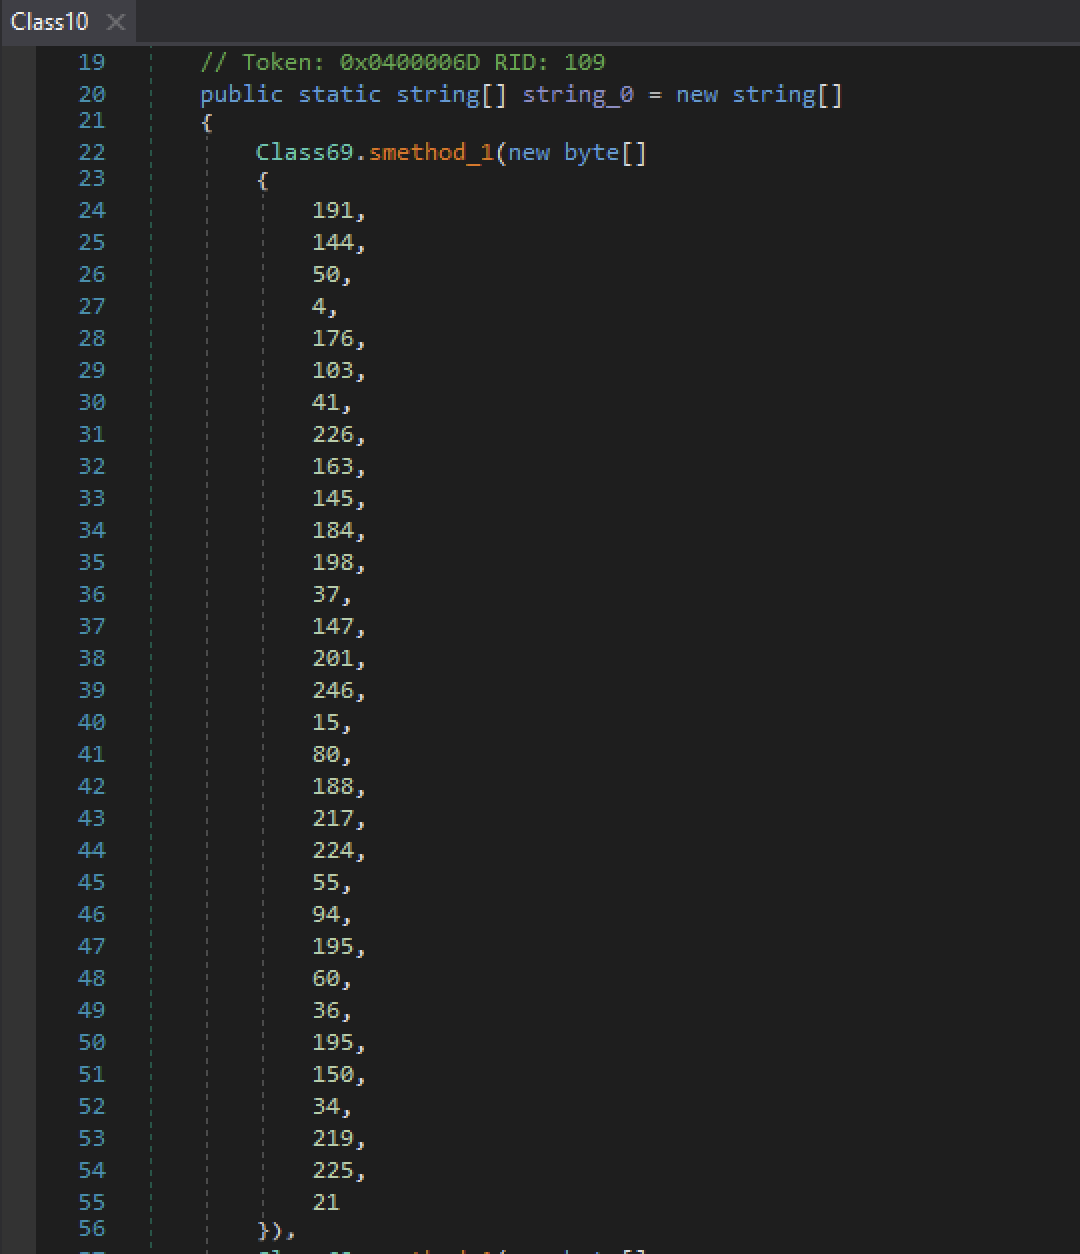

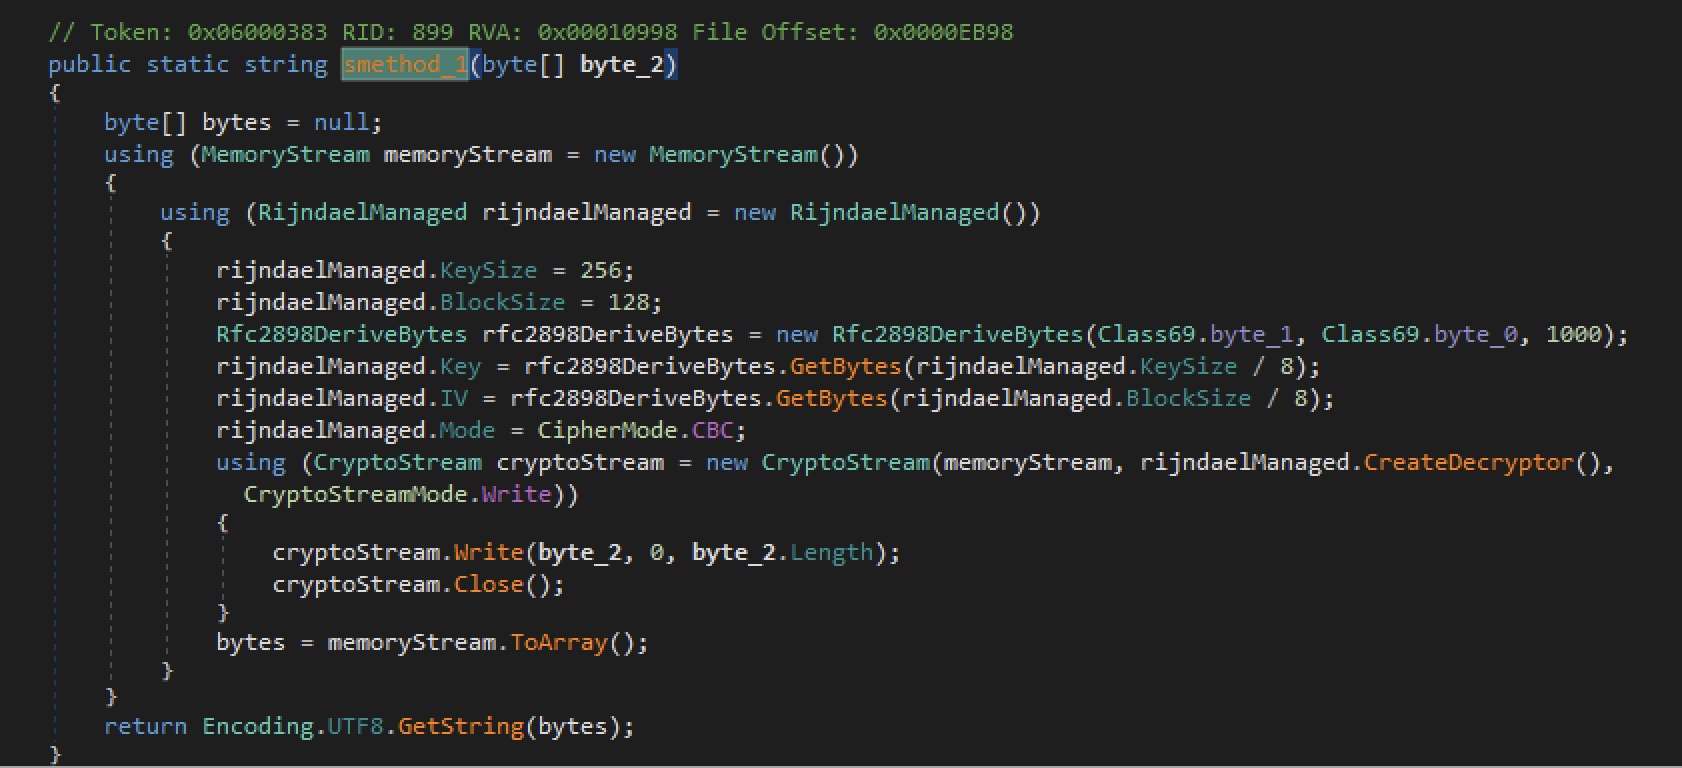

To start out simple lets conver the decryption routine into python, then lets use dnlib to parse out all the decryption calls and decrypt the strings.

In [1]:
from Crypto.Cipher import AES
def decrypt(ctxt, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return cipher.decrypt(ctxt)

# Test with data from dnspy
salt = bytes([0xff,64,191,111,23,3,113,119,231,121,252,112,79,32,114,156])
password = bytes([104,116,116,112,115,58,47,47,103,105,116,104,117,98,46,99,111,109,47,76,105,109,101,114,66,111,121,47,83,116,111,114,109,75,105,116,116,121])
iter_count = 1000
key_size = 256
block_size = 128
key_size_bytes = int(key_size/8)
block_size_bytes = int(block_size/8)
# Generate the key and IV from the hard coded password and salt

# Rfc2898DeriveBytes is a streaming-response object, 
# so concatenating two successive calls is the same as 
# doing one call with both lengths added together

from Crypto.Protocol import KDF
key_bytes = KDF.PBKDF2(password, salt, count=iter_count, dkLen=key_size_bytes+block_size_bytes)

ctxt = bytes([191,144,50,4,176,103,41,226,163,145,184,198,37,147,201,246,15,80,188,217,224,55,94,195,60,36,195,150,34,219,225,21])

ptxt = decrypt(ctxt, key_bytes[:key_size_bytes], key_bytes[key_size_bytes:])
print("Decrypted string: %r" % ptxt)


Decrypted string: b'\\Chromium\\User Data\\\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c\x0c'


In [2]:
# WE have to strip the padding off 
# The padding byte is the pad delta so we just have to take a byte 
# and use it to clip the delta off the end of the data

def unpad(data):
    return data[:-ord(data[len(data)-1:])]

print("Decrypted string: %r" % unpad(ptxt))

Decrypted string: b'\\Chromium\\User Data\\'


## .NET Assembly Analysis 

Ok now that we have a decryption routine we can start to look at programmatically analyzing the .NET assembly seaching for the encrypted strings.

First we will need a way to call .NET methods from Python. This will allow us to both execute functionality in the sample as well as take advantage of multiple .NET analysis tools which are themselves written in .NET. For this we will use the **pythonnet** package (https://github.com/pythonnet/pythonnet/wiki).

#### Pythonnet Setup

Installing pythonnet is as simple as `pip install pythonnet`. If you are on mac you will want to first make sure you have mono installed. Mono is the platfrom independent .NET interpreter that allows you to run .NET anywhere. We will use brew with `brew install mono`.

Once we have pythonnet installed it can be imported into python using `import clr`. CLR stands for Common Language Runtime which is the actual virtual machine that is used to interpret and execute .NET (I think?).

In [12]:
import sys, struct, clr
clr.AddReference("System.Memory")
from System.Reflection import Assembly, MethodInfo, BindingFlags
from System import Type

We are going to use dnlib (https://github.com/0xd4d/dnlib) to interact wiht the .NET assembly. We will need to download the DLL and pass a local path to our python instance. We can build our own from the release ((https://github.com/0xd4d/dnlib/releases) or just download an old compiled version (https://github.com/XenocodeRCE/ConfuserEx-Unpacker/tree/master/DLLS).

In [4]:
DNLIB_PATH = '/tmp/dnlib.dll'
clr.AddReference(DNLIB_PATH)
import dnlib
from dnlib.DotNet import *
from dnlib.DotNet.Emit import OpCodes

Like the dnlib DLL we will need to pass the local path to this file to our Python. Then we can use this path to load the .NET module and assembly.

In [5]:
SAMPLE_PATH = '/tmp/6e4802a21c61d349b2a201ec5143e095b57e033d51bb571b90a53749956beac4.bin'
module = dnlib.DotNet.ModuleDefMD.Load(SAMPLE_PATH)
assembly = Assembly.LoadFrom(SAMPLE_PATH)

Now we need to find the decryption method. The process is straight forward, we will iterate through all of the methods for each type in the module (I think type is what a class is converted to in the IL?) and for each method we will check the instructions to find the decryption method. Actually matching the decryption method is a bit of a hack but basically we just find some stuff that is probably unique to the method and search for that. In this case we are looking for instructions that set the AES key size `SymmetricAlgorithm::set_KeySize` and block size `SymmetricAlgorithm::set_BlockSize`.

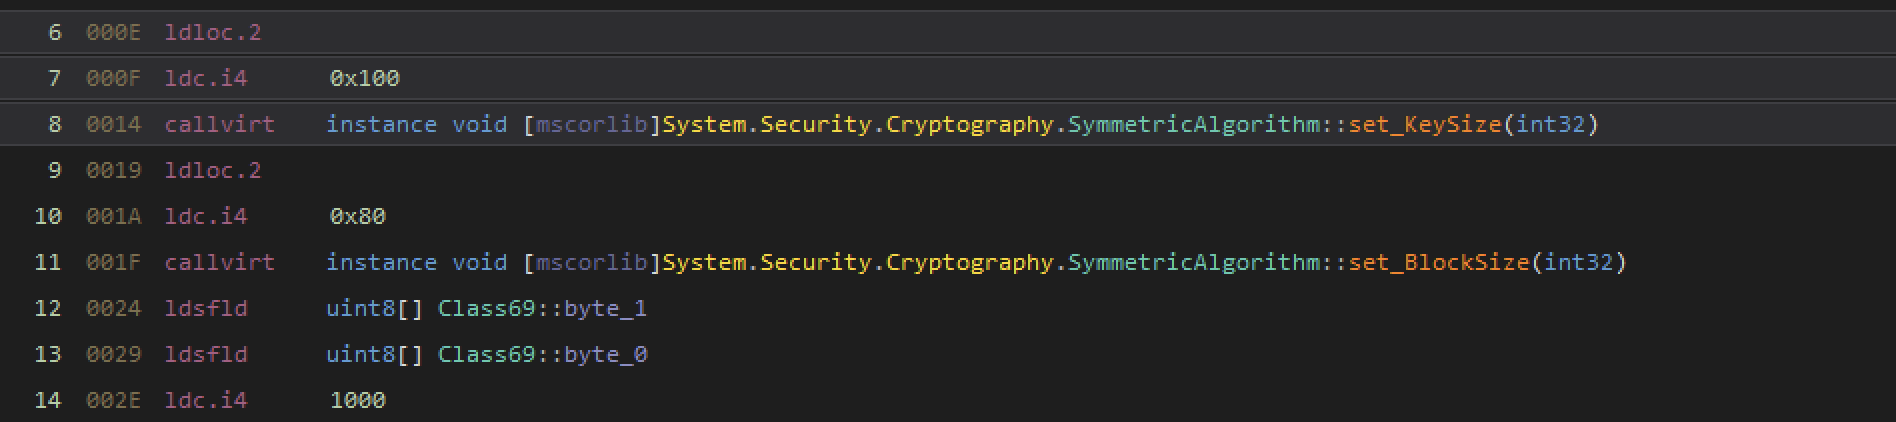


In [6]:
eFlags = BindingFlags.Static | BindingFlags.Public | BindingFlags.NonPublic

# First find the decryption method
decryption_method = None
for mtype in module.GetTypes():
    if not mtype.HasMethods:
        continue
    for method in mtype.Methods:
        if not method.HasBody: 
            continue
        if not method.Body.HasInstructions: 
            continue
        if len(method.Body.Instructions) < 20:
            continue
        # Check the first 20 instructions for the AES key set and block set
        key_set = False 
        block_set = False
        for ptr in range(20):
            if 'SymmetricAlgorithm::set_KeySize' in method.Body.Instructions[ptr].ToString():
                key_set = True
            if 'SymmetricAlgorithm::set_BlockSize' in method.Body.Instructions[ptr].ToString():
                block_set = True
        if key_set and block_set:
            decryption_method =  method
            break
            

if decryption_method != None:
    print(decryption_method.FullName)
else:
    print("Can't find decryption method!")        

System.String Class69::smethod_1(System.Byte[])


Now that we know the decryption method we can save its name then we can search for calls to the method name. The actual name is a bit tricky since we want the class name and the method name in order to disambiguate it. The class name will always preceed the method name with `::` so we can use that to parse the correct string.

In [14]:
# Extract the class name and method name from full method name
full_name = decryption_method.FullName
method_name = str(decryption_method.Name)
decryption_method_name = full_name[:full_name.find(method_name)+len(method_name)].split(" ")[-1]            

Now we can find all the places where the decryption method is called by searching through all the instructions for a `call` to the decryption method name. 

Once we find a call we need to parse out the arguement which is an array containing the encrypted string. This is is a bit tricky since arrays are split into multiple instructions in the IL. 

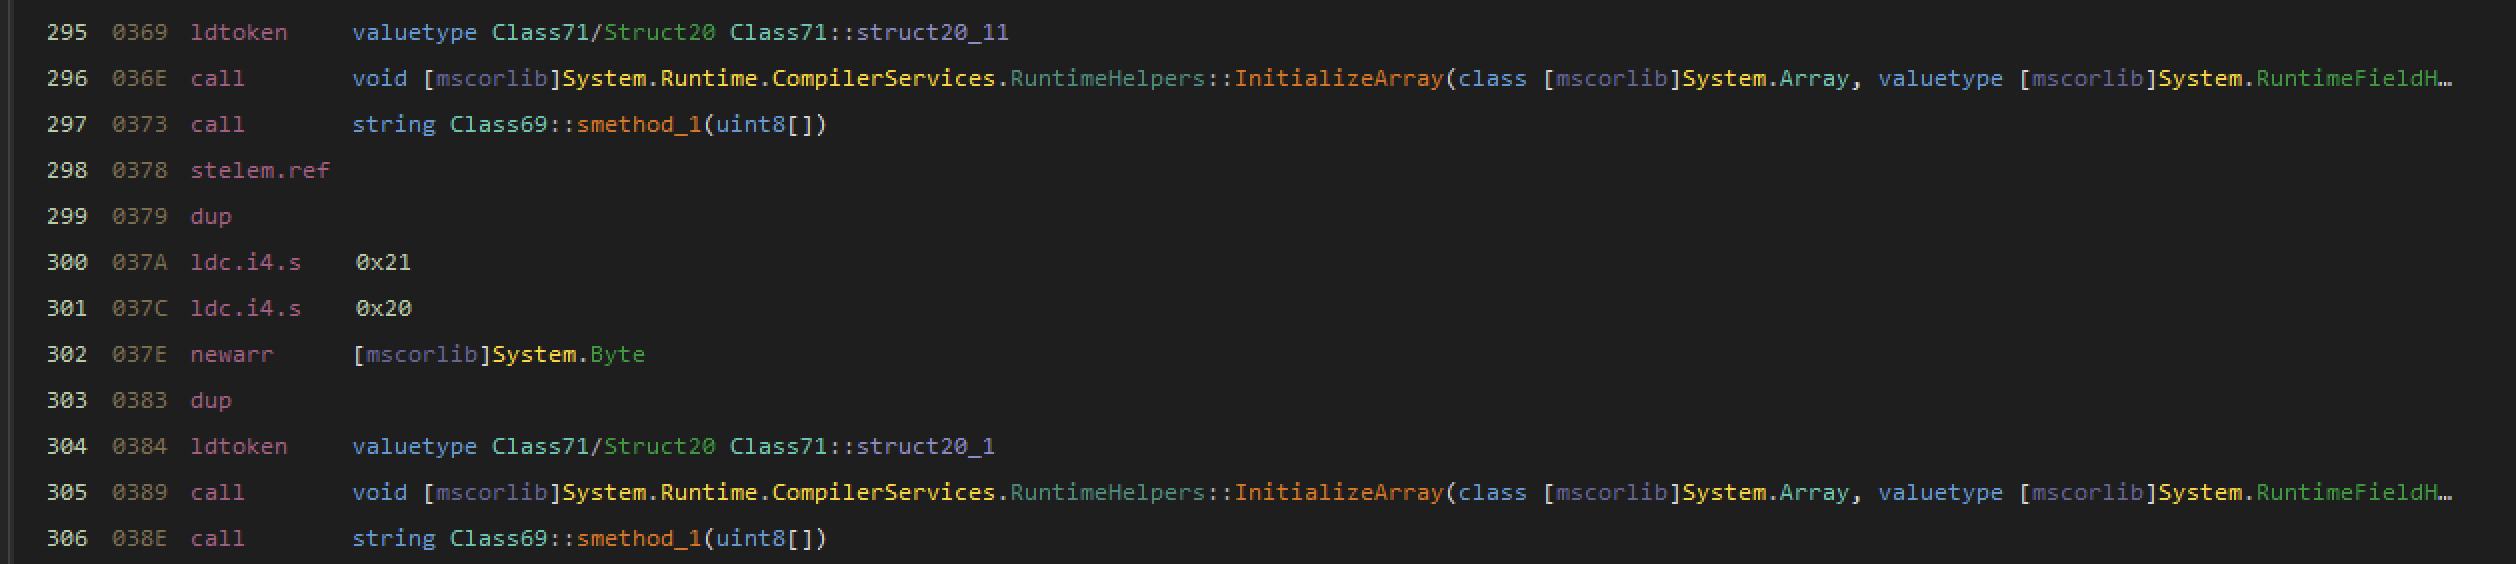

Here we can see the call to the decryption method on line *291* and preceeding the call we can see another call to `InitializeArray` which takes an argument setup with the `ldtoken` call on line *295*. Based on this we can search backwards in the code from the call to the decryption fucntion for the first `ldtoken` instruction which will be loadin the actual data for the array (containing the encrypted string).

In [13]:
# Search for calls to the decryption method and extract the encrypted string that is passed
for mtype in module.GetTypes():
    if not mtype.HasMethods:
        continue
    for method in mtype.Methods:
        if not method.HasBody: 
            continue
        if not method.Body.HasInstructions: 
            continue
        for ptr in range(len(method.Body.Instructions)):
            instruction = method.Body.Instructions[ptr]
            if instruction.OpCode == OpCodes.Call:
                if decryption_method_name in instruction.ToString():
                    # Found call now seach backwards a maximum of 5 instructions for ldtoken to get encrypted string
                    for i in range(1,5):
                        if method.Body.Instructions[ptr-i].OpCode == OpCodes.Ldtoken:
                            print(method.Body.Instructions[ptr-i])
                            mm = method.Body.Instructions[ptr-i]
                            token = mm.Operand.MDToken

IL_0011: ldtoken Class71/Struct20 Class71::struct20_6
IL_002B: ldtoken Class71/Struct20 Class71::struct20_14
IL_0045: ldtoken Class71/Struct20 Class71::struct20_19
IL_005F: ldtoken Class71/Struct20 Class71::struct20_2
IL_0079: ldtoken Class71/Struct22 Class71::struct22_0
IL_0093: ldtoken Class71/Struct20 Class71::struct20_4
IL_00AD: ldtoken Class71/Struct20 Class71::struct20_3
IL_00C7: ldtoken Class71/Struct20 Class71::A25CC6D70519A408CEA3AE72EBFF915335C6E6E613B18720FA746D0D8056559B
IL_00E1: ldtoken Class71/Struct20 Class71::struct20_18
IL_00FC: ldtoken Class71/Struct20 Class71::struct20_9
IL_0117: ldtoken Class71/Struct20 Class71::struct20_24
IL_0132: ldtoken Class71/Struct20 Class71::struct20_25
IL_014D: ldtoken Class71/Struct20 Class71::BF8CAA158736480861E8F91826FFFA6545B27C3EC30153CA68330811329C2A8E
IL_0168: ldtoken Class71/Struct20 Class71::struct20_22
IL_0183: ldtoken Class71/Struct23 Class71::struct23_1
IL_019E: ldtoken Class71/Struct22 Class71::ACDCB1AFB15194F894860BA7E2B85B91B

Now that we have a way to find all of the arrays that contain the encrypted strings we need a way to get the data out of the array. This was very confusing when I was trying to figure it out... hat tip to https://twitter.com/s4tan for all the help <3 
- http://antonioparata.blogspot.com/2018/02/analyzing-nasty-net-protection-of.html
- http://antonioparata.blogspot.com/2013/10/blog-post.html

I'm still not sure this is the best way to do things but basically we grab the first operand from the `ldtoken` instruction which is the token for the field that contains the array. Each array is stored in a field in a class so once we have the token we can search through all the fields in all the classes for the matching token and extract the data. To actually convert the byte array into something we can use in Python we call the `get_InitialValue` method for the field and convert this into a byte string. I think this works because the array is static making the initial value the actual value but I'm not entirely sure.

To simplify the process I created a helper function that will allow us to find and extract the bytes string based on a token.

In [15]:
def get_array_data_by_token(token):
    for mtype in module.GetTypes():
        if mtype.get_HasFields():
            for field in mtype.get_Fields():
                if field.get_MDToken() == token:
                    try:
                        return bytes(field.get_InitialValue())
                    except:
                        return None
    return None

Now we have all the parts and we can put them together to extract and decrypt the strings!

In [16]:
for mtype in module.GetTypes():
    if not mtype.HasMethods:
        continue
    for method in mtype.Methods:
        if not method.HasBody: 
            continue
        if not method.Body.HasInstructions: 
            continue
        for ptr in range(len(method.Body.Instructions)):
            instruction = method.Body.Instructions[ptr]
            if instruction.OpCode == OpCodes.Call:
                if decryption_method_name in instruction.ToString():
                    # Found call now seach backwards a maximum of 5 instructions for ldtoken to get encrypted string
                    for i in range(1,5):
                        if method.Body.Instructions[ptr-i].OpCode == OpCodes.Ldtoken:
                            mm = method.Body.Instructions[ptr-i]
                            token = mm.Operand.MDToken
                            ctxt = get_array_data_by_token(token)
                            if ctxt != None:
                                ptxt = decrypt(ctxt, key_bytes[:key_size_bytes], key_bytes[key_size_bytes:])
                                ptxt = unpad(ptxt)
                                print(ptxt)
                            else:
                                print("Error no array data found for %s" % method.Body.Instructions[ptr-i])

b'\\Chromium\\User Data\\'
b'\\Google\\Chrome\\User Data\\'
b'\\Google(x86)\\Chrome\\User Data\\'
b'\\Opera Software\\'
b'\\MapleStudio\\ChromePlus\\User Data\\'
b'\\Iridium\\User Data\\'
b'\\7Star\\7Star\\User Data\\'
b'\\CentBrowser\\User Data\\'
b'\\Chedot\\User Data\\'
b'\\Vivaldi\\User Data\\'
b'\\Kometa\\User Data\\'
b'\\Elements Browser\\User Data\\'
b'\\Epic Privacy Browser\\User Data'
b'\\uCozMedia\\Uran\\User Data\\'
b'\\Fenrir Inc\\Sleipnir5\\setting\\modules\\ChromiumViewer\\'
b'\\CatalinaGroup\\Citrio\\User Data\\'
b'\\Coowon\\Coowon\\User Data\\'
b'\\liebao\\User Data\\'
b'\\QIP Surf\\User Data\\'
b'\\Orbitum\\User Data\\'
b'\\Comodo\\Dragon\\User Data\\'
b'\\Amigo\\User\\User Data\\'
b'\\Torch\\User Data\\'
b'\\Yandex\\YandexBrowser\\User Data\\'
b'\\Comodo\\User Data\\'
b'\\360Browser\\Browser\\User Data\\'
b'\\Maxthon3\\User Data\\'
b'\\K-Melon\\User Data\\'
b'\\Sputnik\\Sputnik\\User Data\\'
b'\\Nichrome\\User Data\\'
b'\\CocCoc\\Browser\\User Data\\'
b'\\Uran\\User D

Success! Now that we have our string decryption working we can update our code to edit the sample and insert the decrypted strings.